# A Simple Autoencoder

이번 포스트에서는 간단한 Neural Network를 이용해 이미지를 압축(Encode/Compress)하고 복구(Decode/Reconstruct)하는 과정을 실습해보겠습니다.

![Autoencoder](assets/autoencoder_1.png)

원리는 매우 간단합니다.
전체적인 Network의 구성은 매우 심플한 MLP와 비슷합니다.
차이가 있다면, 출력단이 입력 이미지와 같은 형태라는 것입니다.

여기입력 이미지는 (1,784)의 Mnist 이미지입니다.
입력 이미지가 Hidden Layer에서 압축된 표현으로 바뀌었다가 (1,32) 다시 출력단에서 이미지로 복구 (1,784)됩니다.
그렇다면 입력단에서 Hidden Layer까지는 Encoder, Hidden Layer에서 출력단까지는 Decoder가 되겠죠?
만약 Netflix같은 실시간 스트리밍 서비스에서 이를 이용하고자 한다고 가정해 봅시다.
학습시킨 네트워크를 서비스 제공자와 소비자가 가지고 있다가, 그저 Hidden Layer의 값만 주고 받음으로써 원래 이미지를 얻을 수 있는 것입니다.
모든 이미지 (1,784)를 주고받을 필요 없이 단지 압축된 부호(1,32)만 주고받기 때문에 통신효율이 약 24.5배 좋아집니다.


먼저 MNIST 데이터 세트를 압축할 수 있는 간단한 Autoencoder를 구축하겠습니다. 
Autoencoder를 사용하면 입력의 압축된 표현을 만드는 인코더를 통해 입력 데이터를 전달합니다. 그런 다음 이 표현은 디코더를 통해 전달되어 입력 데이터를 재구성합니다. 일반적으로 인코더와 디코더는 신경 네트워크를 통해 구축되고 예제 데이터에 대해 교육됩니다.


이 포스트에서는 인코더와 디코더용 간단한 네트워크 아키텍처를 구축하게 됩니다. 
먼저 라이브러리를 가져오고 데이터 집합을 가져옵니다.

In [3]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


아래에서는 MNIST 데이터 세트의 예제 이미지를 플롯하고 있습니다. 
이것은 손으로 쓴 숫자의 28x28 그레이스케일 이미지입니다.

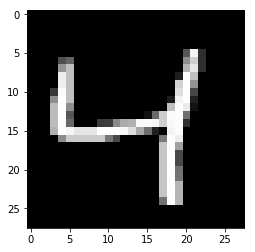

In [5]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [10]:
mnist.train.images.shape[1]

784

우리는 이 사진들을 784개의 길이 벡터로 납작하게 만들어서 Auto Encoder를 훈련시킬 것입니다. 이 데이터셋의 영상은 값이 0과 1 사이에 있도록 이미 표준화되었습니다. 먼저 단일 ReLU 히든 레이어를 가진 가장 간단한 Auto Encoder를 구축해 보겠습니다. 이 레이어는 압축된 표현으로 사용됩니다. 그러면 인코더는 입력 계층과 숨겨진 계층입니다. 디코더는 숨겨진 레이어와 출력 레이어입니다. 영상이 0과 1 사이에서 표준화되므로 입력과 일치하는 값을 얻으려면 출력 계층에서 시그모이드 활성함수을 사용해야 합니다.

![Autoencoder architecture](assets/simple_autoencoder.png)

> **연습:** 아래 셀의 Auto Encoder 그래프를 작성합니다. 입력 영상은 784개의 길이 벡터로 평평해집니다. 대상은 입력과 동일합니다. 그리고 ReLU Activation Function이가 있는 Hidden레이어와 Sigmoid Activation Function이 있는 출력 레이어가 있어야 합니다. 

TensorFlow의 상위 레벨 API 'tf.layers'를 자유롭게 사용하십시오. 예를 들어, [tf.layers.dense](입력, 단위, activation=nnn.relu)](https://www.tensorflow.org/i를 사용합니다. 손실은 교차 엔트로피 손실로 계산해야 하며, 이 'tf.nn'sigoid_cross_entropy_with_logits'에는 편리한 텐서류 기능이 있다. 당신은 'tf.nn.sigoid_cross_entropy_with_logits'가 로짓들을 받지만 재구성된 이미지를 얻기 위해서는 당신은 sigoid 함수를 통과해야 할 것이다.

> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

In [14]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 32 # feel free to change this value
image_size = mnist.train.images.shape[1]

# Input and target placeholders
#tf.placeholder(dtype, shape, name)
inputs_ = tf.placeholder(dtype=tf.float32, shape=(None, image_size), name='inputs')
targets_ = tf.placeholder(dtype=tf.float32, shape=(None, image_size), name='targets')

# Output of hidden layer, single fully connected layer here with ReLU activation
encoded = tf.layers.dense(inputs=inputs_,units=encoding_dim,activation=tf.nn.relu)

# Output layer logits, fully connected layer with no activation
logits = tf.layers.dense(inputs=encoded, units=image_size, activation=None)

# Sigmoid output from logits
#tf.math.sigmoid(x, name)
decoded = tf.nn.sigmoid(logits, name='output')

# Sigmoid cross-entropy loss
#tf.nn.sigmoid_cross_entropy_with_logits(_sentinel, labels, logits, name)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
# Mean of the loss
cost = tf.reduce_mean(loss)

# Adam optimizer
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training

In [15]:
# Create the session
sess = tf.Session()

여기에 네트워크를 훈련시키기 위해 약간의 코드를 쓸 것이다. 저는 여기서 검증에는 별로 관심이 없으니까, 훈련 손실만 감시하겠습니다.

mnist.train.next_batch(batch_size)를 호출하면 (이미지, 레이블)의 tuple이 반환됩니다. 우리는 여기에 있는 라벨에는 관심이 없습니다. 단지 이미지가 필요합니다. 그렇지 않으면 이는 텐서플로우에 대한 꽤 솔직한 교육입니다. sess.run(tf.global_variables_initializer()를 사용하여 변수를 초기화합니다. 그런 다음 최적기를 실행하고 batch_cost, _ = sess.run([cost, opt], feed_rate=feed로 손실을 입힙니다.

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [16]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        feed = {inputs_: batch[0], targets_: batch[0]}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6947
Epoch: 1/20... Training loss: 0.6911
Epoch: 1/20... Training loss: 0.6875
Epoch: 1/20... Training loss: 0.6838
Epoch: 1/20... Training loss: 0.6787
Epoch: 1/20... Training loss: 0.6730
Epoch: 1/20... Training loss: 0.6662
Epoch: 1/20... Training loss: 0.6585
Epoch: 1/20... Training loss: 0.6489
Epoch: 1/20... Training loss: 0.6368
Epoch: 1/20... Training loss: 0.6254
Epoch: 1/20... Training loss: 0.6114
Epoch: 1/20... Training loss: 0.5974
Epoch: 1/20... Training loss: 0.5826
Epoch: 1/20... Training loss: 0.5664
Epoch: 1/20... Training loss: 0.5467
Epoch: 1/20... Training loss: 0.5269
Epoch: 1/20... Training loss: 0.5108
Epoch: 1/20... Training loss: 0.4901
Epoch: 1/20... Training loss: 0.4743
Epoch: 1/20... Training loss: 0.4568
Epoch: 1/20... Training loss: 0.4372
Epoch: 1/20... Training loss: 0.4263
Epoch: 1/20... Training loss: 0.4119
Epoch: 1/20... Training loss: 0.3991
Epoch: 1/20... Training loss: 0.3817
Epoch: 1/20... Training loss: 0.3792
E

Epoch: 1/20... Training loss: 0.1911
Epoch: 1/20... Training loss: 0.1954
Epoch: 1/20... Training loss: 0.1973
Epoch: 1/20... Training loss: 0.1940
Epoch: 1/20... Training loss: 0.1959
Epoch: 1/20... Training loss: 0.1905
Epoch: 1/20... Training loss: 0.1897
Epoch: 1/20... Training loss: 0.1919
Epoch: 1/20... Training loss: 0.1875
Epoch: 1/20... Training loss: 0.1932
Epoch: 1/20... Training loss: 0.1901
Epoch: 1/20... Training loss: 0.1895
Epoch: 1/20... Training loss: 0.1849
Epoch: 1/20... Training loss: 0.1859
Epoch: 1/20... Training loss: 0.1913
Epoch: 1/20... Training loss: 0.1878
Epoch: 1/20... Training loss: 0.1897
Epoch: 1/20... Training loss: 0.1845
Epoch: 1/20... Training loss: 0.1888
Epoch: 1/20... Training loss: 0.1870
Epoch: 1/20... Training loss: 0.1855
Epoch: 1/20... Training loss: 0.1905
Epoch: 1/20... Training loss: 0.1875
Epoch: 1/20... Training loss: 0.1862
Epoch: 1/20... Training loss: 0.1872
Epoch: 1/20... Training loss: 0.1882
Epoch: 1/20... Training loss: 0.1843
E

Epoch: 2/20... Training loss: 0.1613
Epoch: 2/20... Training loss: 0.1593
Epoch: 2/20... Training loss: 0.1500
Epoch: 2/20... Training loss: 0.1544
Epoch: 2/20... Training loss: 0.1557
Epoch: 2/20... Training loss: 0.1627
Epoch: 2/20... Training loss: 0.1516
Epoch: 2/20... Training loss: 0.1568
Epoch: 2/20... Training loss: 0.1576
Epoch: 2/20... Training loss: 0.1513
Epoch: 2/20... Training loss: 0.1622
Epoch: 2/20... Training loss: 0.1580
Epoch: 2/20... Training loss: 0.1549
Epoch: 2/20... Training loss: 0.1538
Epoch: 2/20... Training loss: 0.1637
Epoch: 2/20... Training loss: 0.1549
Epoch: 2/20... Training loss: 0.1500
Epoch: 2/20... Training loss: 0.1544
Epoch: 2/20... Training loss: 0.1573
Epoch: 2/20... Training loss: 0.1537
Epoch: 2/20... Training loss: 0.1528
Epoch: 2/20... Training loss: 0.1484
Epoch: 2/20... Training loss: 0.1513
Epoch: 2/20... Training loss: 0.1537
Epoch: 2/20... Training loss: 0.1582
Epoch: 2/20... Training loss: 0.1515
Epoch: 2/20... Training loss: 0.1544
E

Epoch: 3/20... Training loss: 0.1407
Epoch: 3/20... Training loss: 0.1342
Epoch: 3/20... Training loss: 0.1358
Epoch: 3/20... Training loss: 0.1317
Epoch: 3/20... Training loss: 0.1412
Epoch: 3/20... Training loss: 0.1412
Epoch: 3/20... Training loss: 0.1300
Epoch: 3/20... Training loss: 0.1385
Epoch: 3/20... Training loss: 0.1382
Epoch: 3/20... Training loss: 0.1401
Epoch: 3/20... Training loss: 0.1364
Epoch: 3/20... Training loss: 0.1298
Epoch: 3/20... Training loss: 0.1373
Epoch: 3/20... Training loss: 0.1356
Epoch: 3/20... Training loss: 0.1366
Epoch: 3/20... Training loss: 0.1342
Epoch: 3/20... Training loss: 0.1359
Epoch: 3/20... Training loss: 0.1321
Epoch: 3/20... Training loss: 0.1356
Epoch: 3/20... Training loss: 0.1393
Epoch: 3/20... Training loss: 0.1355
Epoch: 3/20... Training loss: 0.1391
Epoch: 3/20... Training loss: 0.1345
Epoch: 3/20... Training loss: 0.1374
Epoch: 3/20... Training loss: 0.1388
Epoch: 3/20... Training loss: 0.1345
Epoch: 3/20... Training loss: 0.1308
E

Epoch: 4/20... Training loss: 0.1217
Epoch: 4/20... Training loss: 0.1190
Epoch: 4/20... Training loss: 0.1256
Epoch: 4/20... Training loss: 0.1313
Epoch: 4/20... Training loss: 0.1293
Epoch: 4/20... Training loss: 0.1212
Epoch: 4/20... Training loss: 0.1241
Epoch: 4/20... Training loss: 0.1216
Epoch: 4/20... Training loss: 0.1254
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1256
Epoch: 4/20... Training loss: 0.1215
Epoch: 4/20... Training loss: 0.1287
Epoch: 4/20... Training loss: 0.1252
Epoch: 4/20... Training loss: 0.1200
Epoch: 4/20... Training loss: 0.1233
Epoch: 4/20... Training loss: 0.1229
Epoch: 4/20... Training loss: 0.1281
Epoch: 4/20... Training loss: 0.1224
Epoch: 4/20... Training loss: 0.1267
Epoch: 4/20... Training loss: 0.1265
Epoch: 4/20... Training loss: 0.1227
Epoch: 4/20... Training loss: 0.1229
Epoch: 4/20... Training loss: 0.1241
Epoch: 4/20... Training loss: 0.1223
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1272
E

Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1187
Epoch: 4/20... Training loss: 0.1154
Epoch: 4/20... Training loss: 0.1167
Epoch: 4/20... Training loss: 0.1191
Epoch: 4/20... Training loss: 0.1170
Epoch: 4/20... Training loss: 0.1196
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1135
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1190
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1202
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1194
Epoch: 4/20... Training loss: 0.1147
Epoch: 4/20... Training loss: 0.1160
Epoch: 4/20... Training loss: 0.1111
Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1161
Epoch: 4/20... Training loss: 0.1156
Epoch: 4/20... Training loss: 0.1137
Epoch: 4/20... Training loss: 0.1120
Epoch: 4/20... Training loss: 0.1147
E

Epoch: 5/20... Training loss: 0.1092
Epoch: 5/20... Training loss: 0.1122
Epoch: 5/20... Training loss: 0.1083
Epoch: 5/20... Training loss: 0.1098
Epoch: 5/20... Training loss: 0.1065
Epoch: 5/20... Training loss: 0.1122
Epoch: 5/20... Training loss: 0.1129
Epoch: 5/20... Training loss: 0.1082
Epoch: 5/20... Training loss: 0.1073
Epoch: 5/20... Training loss: 0.1089
Epoch: 5/20... Training loss: 0.1042
Epoch: 5/20... Training loss: 0.1122
Epoch: 5/20... Training loss: 0.1048
Epoch: 5/20... Training loss: 0.1073
Epoch: 5/20... Training loss: 0.1106
Epoch: 5/20... Training loss: 0.1110
Epoch: 5/20... Training loss: 0.1118
Epoch: 5/20... Training loss: 0.1085
Epoch: 5/20... Training loss: 0.1070
Epoch: 5/20... Training loss: 0.1071
Epoch: 5/20... Training loss: 0.1062
Epoch: 5/20... Training loss: 0.1083
Epoch: 5/20... Training loss: 0.1106
Epoch: 5/20... Training loss: 0.1083
Epoch: 5/20... Training loss: 0.1110
Epoch: 5/20... Training loss: 0.1071
Epoch: 5/20... Training loss: 0.1094
E

Epoch: 6/20... Training loss: 0.1039
Epoch: 6/20... Training loss: 0.1123
Epoch: 6/20... Training loss: 0.1030
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1066
Epoch: 6/20... Training loss: 0.1056
Epoch: 6/20... Training loss: 0.1040
Epoch: 6/20... Training loss: 0.1048
Epoch: 6/20... Training loss: 0.1064
Epoch: 6/20... Training loss: 0.1049
Epoch: 6/20... Training loss: 0.1070
Epoch: 6/20... Training loss: 0.1072
Epoch: 6/20... Training loss: 0.1083
Epoch: 6/20... Training loss: 0.1045
Epoch: 6/20... Training loss: 0.1060
Epoch: 6/20... Training loss: 0.1040
Epoch: 6/20... Training loss: 0.1016
Epoch: 6/20... Training loss: 0.1044
Epoch: 6/20... Training loss: 0.1009
Epoch: 6/20... Training loss: 0.1070
Epoch: 6/20... Training loss: 0.1033
Epoch: 6/20... Training loss: 0.1049
Epoch: 6/20... Training loss: 0.1058
Epoch: 6/20... Training loss: 0.1027
Epoch: 6/20... Training loss: 0.1044
Epoch: 6/20... Training loss: 0.1010
Epoch: 6/20... Training loss: 0.1040
E

Epoch: 7/20... Training loss: 0.1032
Epoch: 7/20... Training loss: 0.1015
Epoch: 7/20... Training loss: 0.1043
Epoch: 7/20... Training loss: 0.1025
Epoch: 7/20... Training loss: 0.1007
Epoch: 7/20... Training loss: 0.1050
Epoch: 7/20... Training loss: 0.0986
Epoch: 7/20... Training loss: 0.1035
Epoch: 7/20... Training loss: 0.1025
Epoch: 7/20... Training loss: 0.1020
Epoch: 7/20... Training loss: 0.1027
Epoch: 7/20... Training loss: 0.1028
Epoch: 7/20... Training loss: 0.1038
Epoch: 7/20... Training loss: 0.1026
Epoch: 7/20... Training loss: 0.1028
Epoch: 7/20... Training loss: 0.0992
Epoch: 7/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1017
Epoch: 7/20... Training loss: 0.1000
Epoch: 7/20... Training loss: 0.1007
Epoch: 7/20... Training loss: 0.1062
Epoch: 7/20... Training loss: 0.1007
Epoch: 7/20... Training loss: 0.1048
Epoch: 7/20... Training loss: 0.1037
Epoch: 7/20... Training loss: 0.1001
Epoch: 7/20... Training loss: 0.1057
Epoch: 7/20... Training loss: 0.0982
E

Epoch: 7/20... Training loss: 0.1004
Epoch: 7/20... Training loss: 0.1024
Epoch: 7/20... Training loss: 0.0981
Epoch: 7/20... Training loss: 0.0986
Epoch: 7/20... Training loss: 0.0999
Epoch: 7/20... Training loss: 0.0997
Epoch: 7/20... Training loss: 0.0996
Epoch: 7/20... Training loss: 0.0979
Epoch: 7/20... Training loss: 0.0983
Epoch: 7/20... Training loss: 0.1000
Epoch: 7/20... Training loss: 0.1001
Epoch: 7/20... Training loss: 0.0973
Epoch: 7/20... Training loss: 0.1008
Epoch: 7/20... Training loss: 0.0968
Epoch: 7/20... Training loss: 0.0959
Epoch: 7/20... Training loss: 0.0999
Epoch: 7/20... Training loss: 0.1004
Epoch: 7/20... Training loss: 0.0960
Epoch: 7/20... Training loss: 0.0969
Epoch: 7/20... Training loss: 0.0990
Epoch: 7/20... Training loss: 0.0986
Epoch: 7/20... Training loss: 0.1010
Epoch: 7/20... Training loss: 0.0992
Epoch: 7/20... Training loss: 0.0993
Epoch: 7/20... Training loss: 0.1007
Epoch: 7/20... Training loss: 0.0968
Epoch: 7/20... Training loss: 0.0974
E

Epoch: 8/20... Training loss: 0.0999
Epoch: 8/20... Training loss: 0.0957
Epoch: 8/20... Training loss: 0.0963
Epoch: 8/20... Training loss: 0.0977
Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.0972
Epoch: 8/20... Training loss: 0.0965
Epoch: 8/20... Training loss: 0.0963
Epoch: 8/20... Training loss: 0.0980
Epoch: 8/20... Training loss: 0.0963
Epoch: 8/20... Training loss: 0.0967
Epoch: 8/20... Training loss: 0.0933
Epoch: 8/20... Training loss: 0.0987
Epoch: 8/20... Training loss: 0.0974
Epoch: 8/20... Training loss: 0.0965
Epoch: 8/20... Training loss: 0.0993
Epoch: 8/20... Training loss: 0.0969
Epoch: 8/20... Training loss: 0.0958
Epoch: 8/20... Training loss: 0.0981
Epoch: 8/20... Training loss: 0.0967
Epoch: 8/20... Training loss: 0.0924
Epoch: 8/20... Training loss: 0.0953
Epoch: 8/20... Training loss: 0.0995
Epoch: 8/20... Training loss: 0.0997
Epoch: 8/20... Training loss: 0.0993
Epoch: 8/20... Training loss: 0.0969
Epoch: 8/20... Training loss: 0.1000
E

Epoch: 9/20... Training loss: 0.0967
Epoch: 9/20... Training loss: 0.0927
Epoch: 9/20... Training loss: 0.0980
Epoch: 9/20... Training loss: 0.0985
Epoch: 9/20... Training loss: 0.0980
Epoch: 9/20... Training loss: 0.0967
Epoch: 9/20... Training loss: 0.0953
Epoch: 9/20... Training loss: 0.0967
Epoch: 9/20... Training loss: 0.0983
Epoch: 9/20... Training loss: 0.0980
Epoch: 9/20... Training loss: 0.0971
Epoch: 9/20... Training loss: 0.0972
Epoch: 9/20... Training loss: 0.0937
Epoch: 9/20... Training loss: 0.0968
Epoch: 9/20... Training loss: 0.0955
Epoch: 9/20... Training loss: 0.0948
Epoch: 9/20... Training loss: 0.0950
Epoch: 9/20... Training loss: 0.0965
Epoch: 9/20... Training loss: 0.0950
Epoch: 9/20... Training loss: 0.0933
Epoch: 9/20... Training loss: 0.0967
Epoch: 9/20... Training loss: 0.0941
Epoch: 9/20... Training loss: 0.0950
Epoch: 9/20... Training loss: 0.0977
Epoch: 9/20... Training loss: 0.0963
Epoch: 9/20... Training loss: 0.0996
Epoch: 9/20... Training loss: 0.0970
E

Epoch: 10/20... Training loss: 0.0959
Epoch: 10/20... Training loss: 0.0970
Epoch: 10/20... Training loss: 0.0956
Epoch: 10/20... Training loss: 0.0973
Epoch: 10/20... Training loss: 0.0915
Epoch: 10/20... Training loss: 0.0959
Epoch: 10/20... Training loss: 0.0967
Epoch: 10/20... Training loss: 0.0968
Epoch: 10/20... Training loss: 0.0975
Epoch: 10/20... Training loss: 0.0961
Epoch: 10/20... Training loss: 0.0965
Epoch: 10/20... Training loss: 0.0985
Epoch: 10/20... Training loss: 0.0948
Epoch: 10/20... Training loss: 0.0972
Epoch: 10/20... Training loss: 0.0965
Epoch: 10/20... Training loss: 0.1001
Epoch: 10/20... Training loss: 0.0929
Epoch: 10/20... Training loss: 0.0992
Epoch: 10/20... Training loss: 0.0964
Epoch: 10/20... Training loss: 0.0959
Epoch: 10/20... Training loss: 0.0966
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0983
Epoch: 10/20... Training loss: 0.0972
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0944
Epoch: 10/20

Epoch: 10/20... Training loss: 0.0981
Epoch: 10/20... Training loss: 0.0944
Epoch: 10/20... Training loss: 0.0977
Epoch: 10/20... Training loss: 0.0951
Epoch: 11/20... Training loss: 0.0978
Epoch: 11/20... Training loss: 0.0961
Epoch: 11/20... Training loss: 0.0961
Epoch: 11/20... Training loss: 0.0956
Epoch: 11/20... Training loss: 0.0937
Epoch: 11/20... Training loss: 0.0977
Epoch: 11/20... Training loss: 0.0963
Epoch: 11/20... Training loss: 0.0951
Epoch: 11/20... Training loss: 0.0942
Epoch: 11/20... Training loss: 0.0971
Epoch: 11/20... Training loss: 0.0950
Epoch: 11/20... Training loss: 0.0958
Epoch: 11/20... Training loss: 0.0964
Epoch: 11/20... Training loss: 0.0919
Epoch: 11/20... Training loss: 0.0950
Epoch: 11/20... Training loss: 0.0970
Epoch: 11/20... Training loss: 0.0967
Epoch: 11/20... Training loss: 0.0947
Epoch: 11/20... Training loss: 0.0934
Epoch: 11/20... Training loss: 0.0977
Epoch: 11/20... Training loss: 0.0947
Epoch: 11/20... Training loss: 0.0926
Epoch: 11/20

Epoch: 11/20... Training loss: 0.0915
Epoch: 11/20... Training loss: 0.0947
Epoch: 11/20... Training loss: 0.0958
Epoch: 11/20... Training loss: 0.0924
Epoch: 11/20... Training loss: 0.0946
Epoch: 11/20... Training loss: 0.0950
Epoch: 11/20... Training loss: 0.0937
Epoch: 11/20... Training loss: 0.0941
Epoch: 11/20... Training loss: 0.0941
Epoch: 11/20... Training loss: 0.0947
Epoch: 11/20... Training loss: 0.0941
Epoch: 11/20... Training loss: 0.0947
Epoch: 11/20... Training loss: 0.0961
Epoch: 11/20... Training loss: 0.0943
Epoch: 11/20... Training loss: 0.0932
Epoch: 11/20... Training loss: 0.0958
Epoch: 11/20... Training loss: 0.0949
Epoch: 11/20... Training loss: 0.0955
Epoch: 11/20... Training loss: 0.0953
Epoch: 11/20... Training loss: 0.0943
Epoch: 11/20... Training loss: 0.0941
Epoch: 11/20... Training loss: 0.0995
Epoch: 11/20... Training loss: 0.0970
Epoch: 11/20... Training loss: 0.0964
Epoch: 11/20... Training loss: 0.0910
Epoch: 11/20... Training loss: 0.0930
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0943
Epoch: 12/20... Training loss: 0.0980
Epoch: 12/20... Training loss: 0.0975
Epoch: 12/20... Training loss: 0.0946
Epoch: 12/20... Training loss: 0.0976
Epoch: 12/20... Training loss: 0.0925
Epoch: 12/20... Training loss: 0.0913
Epoch: 12/20... Training loss: 0.0942
Epoch: 12/20... Training loss: 0.0957
Epoch: 12/20... Training loss: 0.0976
Epoch: 12/20... Training loss: 0.0972
Epoch: 12/20... Training loss: 0.0926
Epoch: 12/20... Training loss: 0.0936
Epoch: 12/20... Training loss: 0.0978
Epoch: 12/20... Training loss: 0.0978
Epoch: 12/20... Training loss: 0.0963
Epoch: 12/20... Training loss: 0.0943
Epoch: 12/20... Training loss: 0.0924
Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.0977
Epoch: 12/20... Training loss: 0.0985
Epoch: 12/20... Training loss: 0.0951
Epoch: 12/20... Training loss: 0.0912
Epoch: 12/20... Training loss: 0.0958
Epoch: 12/20... Training loss: 0.0956
Epoch: 12/20... Training loss: 0.0938
Epoch: 12/20

Epoch: 13/20... Training loss: 0.0951
Epoch: 13/20... Training loss: 0.0960
Epoch: 13/20... Training loss: 0.0921
Epoch: 13/20... Training loss: 0.0964
Epoch: 13/20... Training loss: 0.0944
Epoch: 13/20... Training loss: 0.0947
Epoch: 13/20... Training loss: 0.0971
Epoch: 13/20... Training loss: 0.0944
Epoch: 13/20... Training loss: 0.0972
Epoch: 13/20... Training loss: 0.0934
Epoch: 13/20... Training loss: 0.0976
Epoch: 13/20... Training loss: 0.0960
Epoch: 13/20... Training loss: 0.0944
Epoch: 13/20... Training loss: 0.0926
Epoch: 13/20... Training loss: 0.0943
Epoch: 13/20... Training loss: 0.0927
Epoch: 13/20... Training loss: 0.0939
Epoch: 13/20... Training loss: 0.0958
Epoch: 13/20... Training loss: 0.0934
Epoch: 13/20... Training loss: 0.0921
Epoch: 13/20... Training loss: 0.0937
Epoch: 13/20... Training loss: 0.0921
Epoch: 13/20... Training loss: 0.0971
Epoch: 13/20... Training loss: 0.0962
Epoch: 13/20... Training loss: 0.0948
Epoch: 13/20... Training loss: 0.0948
Epoch: 13/20

Epoch: 13/20... Training loss: 0.0957
Epoch: 13/20... Training loss: 0.0958
Epoch: 13/20... Training loss: 0.0892
Epoch: 13/20... Training loss: 0.0912
Epoch: 13/20... Training loss: 0.0956
Epoch: 13/20... Training loss: 0.0927
Epoch: 13/20... Training loss: 0.0934
Epoch: 13/20... Training loss: 0.0950
Epoch: 13/20... Training loss: 0.0918
Epoch: 13/20... Training loss: 0.0944
Epoch: 13/20... Training loss: 0.0935
Epoch: 13/20... Training loss: 0.0918
Epoch: 13/20... Training loss: 0.0945
Epoch: 13/20... Training loss: 0.0930
Epoch: 13/20... Training loss: 0.0928
Epoch: 14/20... Training loss: 0.0920
Epoch: 14/20... Training loss: 0.0927
Epoch: 14/20... Training loss: 0.0922
Epoch: 14/20... Training loss: 0.0931
Epoch: 14/20... Training loss: 0.0936
Epoch: 14/20... Training loss: 0.0916
Epoch: 14/20... Training loss: 0.0970
Epoch: 14/20... Training loss: 0.0943
Epoch: 14/20... Training loss: 0.0938
Epoch: 14/20... Training loss: 0.0931
Epoch: 14/20... Training loss: 0.0922
Epoch: 14/20

Epoch: 14/20... Training loss: 0.0942
Epoch: 14/20... Training loss: 0.0934
Epoch: 14/20... Training loss: 0.0944
Epoch: 14/20... Training loss: 0.0957
Epoch: 14/20... Training loss: 0.0944
Epoch: 14/20... Training loss: 0.0942
Epoch: 14/20... Training loss: 0.0969
Epoch: 14/20... Training loss: 0.0934
Epoch: 14/20... Training loss: 0.0937
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0956
Epoch: 14/20... Training loss: 0.0938
Epoch: 14/20... Training loss: 0.0917
Epoch: 14/20... Training loss: 0.0924
Epoch: 14/20... Training loss: 0.0972
Epoch: 14/20... Training loss: 0.0950
Epoch: 14/20... Training loss: 0.0953
Epoch: 14/20... Training loss: 0.0951
Epoch: 14/20... Training loss: 0.0949
Epoch: 14/20... Training loss: 0.0949
Epoch: 14/20... Training loss: 0.0939
Epoch: 14/20... Training loss: 0.0917
Epoch: 14/20... Training loss: 0.0948
Epoch: 14/20... Training loss: 0.0945
Epoch: 14/20... Training loss: 0.0939
Epoch: 14/20... Training loss: 0.0961
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0962
Epoch: 15/20... Training loss: 0.0969
Epoch: 15/20... Training loss: 0.0926
Epoch: 15/20... Training loss: 0.0923
Epoch: 15/20... Training loss: 0.0916
Epoch: 15/20... Training loss: 0.0970
Epoch: 15/20... Training loss: 0.0959
Epoch: 15/20... Training loss: 0.0942
Epoch: 15/20... Training loss: 0.0863
Epoch: 15/20... Training loss: 0.0939
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.0924
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.0910
Epoch: 15/20... Training loss: 0.0927
Epoch: 15/20... Training loss: 0.0936
Epoch: 15/20... Training loss: 0.0942
Epoch: 15/20... Training loss: 0.0900
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.0957
Epoch: 15/20... Training loss: 0.0945
Epoch: 15/20... Training loss: 0.0938
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.0938
Epoch: 15/20... Training loss: 0.0936
Epoch: 15/20... Training loss: 0.0932
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0954
Epoch: 16/20... Training loss: 0.0947
Epoch: 16/20... Training loss: 0.0939
Epoch: 16/20... Training loss: 0.0974
Epoch: 16/20... Training loss: 0.0953
Epoch: 16/20... Training loss: 0.0921
Epoch: 16/20... Training loss: 0.0968
Epoch: 16/20... Training loss: 0.0943
Epoch: 16/20... Training loss: 0.0937
Epoch: 16/20... Training loss: 0.0920
Epoch: 16/20... Training loss: 0.0930
Epoch: 16/20... Training loss: 0.0916
Epoch: 16/20... Training loss: 0.0925
Epoch: 16/20... Training loss: 0.0934
Epoch: 16/20... Training loss: 0.0951
Epoch: 16/20... Training loss: 0.0957
Epoch: 16/20... Training loss: 0.0938
Epoch: 16/20... Training loss: 0.0920
Epoch: 16/20... Training loss: 0.0948
Epoch: 16/20... Training loss: 0.0922
Epoch: 16/20... Training loss: 0.0963
Epoch: 16/20... Training loss: 0.0941
Epoch: 16/20... Training loss: 0.0905
Epoch: 16/20... Training loss: 0.0987
Epoch: 16/20... Training loss: 0.0965
Epoch: 16/20... Training loss: 0.0942
Epoch: 16/20

Epoch: 16/20... Training loss: 0.0924
Epoch: 17/20... Training loss: 0.0934
Epoch: 17/20... Training loss: 0.0900
Epoch: 17/20... Training loss: 0.0966
Epoch: 17/20... Training loss: 0.0960
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20... Training loss: 0.0960
Epoch: 17/20... Training loss: 0.0950
Epoch: 17/20... Training loss: 0.0921
Epoch: 17/20... Training loss: 0.0941
Epoch: 17/20... Training loss: 0.0946
Epoch: 17/20... Training loss: 0.0954
Epoch: 17/20... Training loss: 0.0929
Epoch: 17/20... Training loss: 0.0942
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0944
Epoch: 17/20... Training loss: 0.0986
Epoch: 17/20... Training loss: 0.0940
Epoch: 17/20... Training loss: 0.0927
Epoch: 17/20... Training loss: 0.0963
Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.0925
Epoch: 17/20... Training loss: 0.0924
Epoch: 17/20... Training loss: 0.0939
Epoch: 17/20... Training loss: 0.0922
Epoch: 17/20... Training loss: 0.0931
Epoch: 17/20

Epoch: 17/20... Training loss: 0.0937
Epoch: 17/20... Training loss: 0.0936
Epoch: 17/20... Training loss: 0.0942
Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.0931
Epoch: 17/20... Training loss: 0.0930
Epoch: 17/20... Training loss: 0.0943
Epoch: 17/20... Training loss: 0.0933
Epoch: 17/20... Training loss: 0.0944
Epoch: 17/20... Training loss: 0.0931
Epoch: 17/20... Training loss: 0.0916
Epoch: 17/20... Training loss: 0.0883
Epoch: 17/20... Training loss: 0.0951
Epoch: 17/20... Training loss: 0.0957
Epoch: 17/20... Training loss: 0.0974
Epoch: 17/20... Training loss: 0.0948
Epoch: 17/20... Training loss: 0.0904
Epoch: 17/20... Training loss: 0.0985
Epoch: 17/20... Training loss: 0.0914
Epoch: 17/20... Training loss: 0.0912
Epoch: 17/20... Training loss: 0.0933
Epoch: 17/20... Training loss: 0.0927
Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.0957
Epoch: 17/20... Training loss: 0.0958
Epoch: 17/20... Training loss: 0.0944
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0926
Epoch: 18/20... Training loss: 0.0914
Epoch: 18/20... Training loss: 0.0931
Epoch: 18/20... Training loss: 0.0958
Epoch: 18/20... Training loss: 0.0917
Epoch: 18/20... Training loss: 0.0930
Epoch: 18/20... Training loss: 0.0970
Epoch: 18/20... Training loss: 0.0928
Epoch: 18/20... Training loss: 0.0902
Epoch: 18/20... Training loss: 0.0952
Epoch: 18/20... Training loss: 0.0920
Epoch: 18/20... Training loss: 0.0907
Epoch: 18/20... Training loss: 0.0920
Epoch: 18/20... Training loss: 0.0905
Epoch: 18/20... Training loss: 0.0907
Epoch: 18/20... Training loss: 0.0929
Epoch: 18/20... Training loss: 0.0954
Epoch: 18/20... Training loss: 0.0945
Epoch: 18/20... Training loss: 0.0954
Epoch: 18/20... Training loss: 0.0888
Epoch: 18/20... Training loss: 0.0922
Epoch: 18/20... Training loss: 0.0949
Epoch: 18/20... Training loss: 0.0908
Epoch: 18/20... Training loss: 0.0920
Epoch: 18/20... Training loss: 0.0908
Epoch: 18/20... Training loss: 0.0940
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0912
Epoch: 19/20... Training loss: 0.0922
Epoch: 19/20... Training loss: 0.0938
Epoch: 19/20... Training loss: 0.0946
Epoch: 19/20... Training loss: 0.0916
Epoch: 19/20... Training loss: 0.0873
Epoch: 19/20... Training loss: 0.0950
Epoch: 19/20... Training loss: 0.0937
Epoch: 19/20... Training loss: 0.0915
Epoch: 19/20... Training loss: 0.0941
Epoch: 19/20... Training loss: 0.0931
Epoch: 19/20... Training loss: 0.0927
Epoch: 19/20... Training loss: 0.0913
Epoch: 19/20... Training loss: 0.0928
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0946
Epoch: 19/20... Training loss: 0.0914
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0990
Epoch: 19/20... Training loss: 0.0948
Epoch: 19/20... Training loss: 0.0921
Epoch: 19/20... Training loss: 0.0907
Epoch: 19/20... Training loss: 0.0955
Epoch: 19/20... Training loss: 0.0949
Epoch: 19/20... Training loss: 0.0923
Epoch: 19/20... Training loss: 0.0956
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0931
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0940
Epoch: 20/20... Training loss: 0.0917
Epoch: 20/20... Training loss: 0.0932
Epoch: 20/20... Training loss: 0.0907
Epoch: 20/20... Training loss: 0.0971
Epoch: 20/20... Training loss: 0.0934
Epoch: 20/20... Training loss: 0.0937
Epoch: 20/20... Training loss: 0.0920
Epoch: 20/20... Training loss: 0.0936
Epoch: 20/20... Training loss: 0.0946
Epoch: 20/20... Training loss: 0.0936
Epoch: 20/20... Training loss: 0.0940
Epoch: 20/20... Training loss: 0.0928
Epoch: 20/20... Training loss: 0.0948
Epoch: 20/20... Training loss: 0.0946
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.0937
Epoch: 20/20... Training loss: 0.0945
Epoch: 20/20... Training loss: 0.0952
Epoch: 20/20... Training loss: 0.0906
Epoch: 20/20... Training loss: 0.0923
Epoch: 20/20... Training loss: 0.0915
Epoch: 20/20... Training loss: 0.0910
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0935
Epoch: 20/20... Training loss: 0.0939
Epoch: 20/20... Training loss: 0.0949
Epoch: 20/20... Training loss: 0.0917
Epoch: 20/20... Training loss: 0.0930
Epoch: 20/20... Training loss: 0.0928
Epoch: 20/20... Training loss: 0.0908
Epoch: 20/20... Training loss: 0.0949
Epoch: 20/20... Training loss: 0.0922
Epoch: 20/20... Training loss: 0.0917
Epoch: 20/20... Training loss: 0.0956
Epoch: 20/20... Training loss: 0.0921
Epoch: 20/20... Training loss: 0.0918
Epoch: 20/20... Training loss: 0.0931
Epoch: 20/20... Training loss: 0.0904
Epoch: 20/20... Training loss: 0.0943
Epoch: 20/20... Training loss: 0.0920
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0918
Epoch: 20/20... Training loss: 0.0945
Epoch: 20/20... Training loss: 0.0950
Epoch: 20/20... Training loss: 0.0910
Epoch: 20/20... Training loss: 0.0928
Epoch: 20/20... Training loss: 0.0935
Epoch: 20/20... Training loss: 0.0922
Epoch: 20/20

## Checking out the results

아래에서는 일부 테스트 영상을 재구성과 함께 표시합니다. 
일부 부위의 흐릿한 부분만 제외하면 대부분 이것들은 꽤 좋아 보입니다.

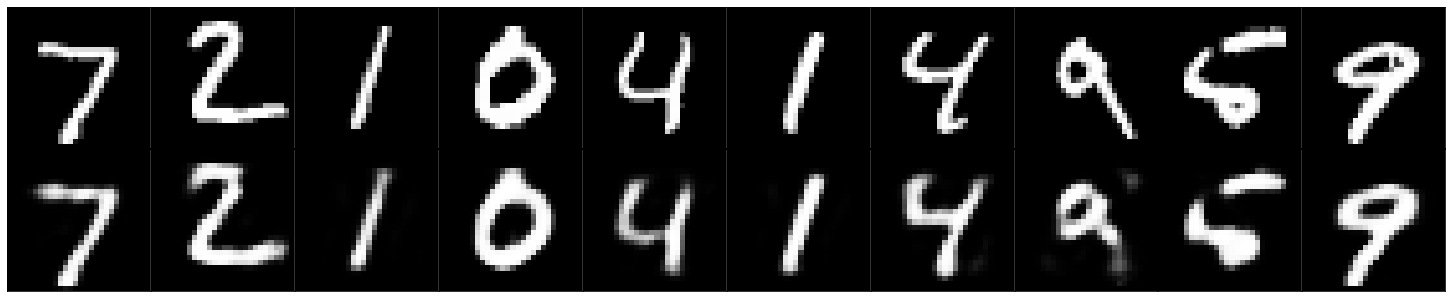

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Up Next

여기서는 이미지를 다루고 있으므로, (일반적으로) 결로 층을 사용하여 더 나은 성능을 얻을 수 있습니다. 
다음으로, 우리는 대각선 층을 가진 더 나은 자동 입력기를 만들 것입니다.

실제로 자동 완성기는 JPEG나 MP3와 같은 일반적인 방법에 비해 압축 능력이 뛰어나지 않습니다. 하지만 소음 감소에도 사용되고 있습니다.